# Understanding Crime Rates in London, England

## Project Overview

In this project, I aim to analyze and understand the crime rate in London, England, with a particular focus on violent crimes. The primary objective is to explore the patterns of violent crime rates and identify when they are most likely to occur throughout the year.

## Dataset Description

The dataset used in this analysis includes all crimes (both violent and non-violent) reported in London between 2008 and 2016. However, the dataset does not explicitly categorize crimes as violent or non-violent. Therefore, during the preprocessing phase, we will need to address this limitation by defining and separating violent crimes from non-violent ones.

Additionally, we will need to account for the months when daylight saving time (DST) is in effect, as this could influence the patterns of crime.

## Hypothesis

My initial hypothesis is that violent crime rates tend to increase during periods when daylight saving time is not in effect. This is because the nights are longer during these periods, potentially providing more opportunities for violent crimes to occur under the cover of darkness.

## Next Steps

1. **Data Preprocessing**: 
   - Categorize crimes as violent or non-violent.
   - Identify and label the months when daylight saving time is in effect.

2. **Exploratory Data Analysis (EDA)**:
   - Analyze crime trends over the years.
   - Compare crime rates during DST and non-DST periods.

3. **Statistical Analysis**:
   - Test the hypothesis by comparing violent crime rates during DST and non-DST periods.

4. **Visualization**:
   - Create visualizations to illustrate crime patterns and support findings.

By the end of this notebook, I hope to provide insights into the relationship between daylight saving time and violent crime rates in London.

## 1. Loading the Data
We start by loading the dataset and examining its structure.

In [1]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
from statsmodels.stats.proportion import proportions_ztest
import statsmodels.api as sm

%matplotlib inline
pd.set_option('display.max_columns', None)

In [2]:
# read csv and import data
df = pd.read_csv('./data/london_crime.csv')

# make a copy
crime_df = df.copy()

# Display the first few rows
df.head()

,lsoa_code,borough,major_category,minor_category,value,year,month
0,E01001116,Croydon,Burglary,Burglary in Other Buildings,0,2016,11
1,E01001646,Greenwich,Violence Against the Person,Other violence,0,2016,11
2,E01000677,Bromley,Violence Against the Person,Other violence,0,2015,5
3,E01003774,Redbridge,Burglary,Burglary in Other Buildings,0,2016,3
4,E01004563,Wandsworth,Robbery,Personal Property,0,2008,6


In [3]:
print(f"There are a total of {crime_df.shape[0]} rows in the dataset.")

There are a total of 13490604 rows in the dataset.


In [4]:
crime_df.borough.value_counts()

borough
Croydon                   602100
Barnet                    572832
Ealing                    549396
Bromley                   523908
Lambeth                   519048
Enfield                   511164
Wandsworth                498636
Brent                     490644
Lewisham                  485136
Southwark                 483300
Newham                    471420
Redbridge                 445716
Hillingdon                442584
Greenwich                 421200
Hackney                   417744
Haringey                  413856
Tower Hamlets             412128
Waltham Forest            406296
Havering                  399600
Hounslow                  395928
Bexley                    385668
Camden                    378432
Westminster               366660
Harrow                    365688
Islington                 359208
Merton                    339876
Hammersmith and Fulham    328752
Sutton                    322488
Barking and Dagenham      311040
Richmond upon Thames      304128
Ke

It appears that the majority of crimes occurred in the Croydon borough, followed by Barnet and Ealing. Interestingly, the City of London recorded the lowest number of crimes, which is somewhat surprising given that I expected the city center to have higher crime rates. Additionally, the crime rate in the City of London is nearly one-third that of the second-lowest area, Kingston upon Thames.

## 2. Data Overview
Let's get a sense of the dataset's size, columns, and missing values.


In [5]:
crime_df.month.value_counts().sort_index()

month
1     1124217
2     1124217
3     1124217
4     1124217
5     1124217
6     1124217
7     1124217
8     1124217
9     1124217
10    1124217
11    1124217
12    1124217
Name: count, dtype: int64

In [6]:
crime_df.value.min(), crime_df.value.max()

(0, 309)

In [7]:
crime_df.isnull().sum()

lsoa_code         0
borough           0
major_category    0
minor_category    0
value             0
year              0
month             0
dtype: int64

In [8]:
crime_df.duplicated().sum()

0

Fortunately, the dataset contains no duplicates or null values. That said, even if duplicates were present, removing them might not be appropriate, as the same type of crime could occur in the same location and within the same month.

## 3. Crime Distribution by Category
We need to categorize crimes as violent or non-violent. For this analysis, we will define violent crimes as those involving physical harm (e.g., assault, robbery). Let's create a new column to classify crimes.

In [9]:
crime_df.major_category.unique()

array(['Burglary', 'Violence Against the Person', 'Robbery',
       'Theft and Handling', 'Criminal Damage', 'Drugs',
       'Fraud or Forgery', 'Other Notifiable Offences', 'Sexual Offences'],
      dtype=object)

In [10]:
crime_df.minor_category.unique()

array(['Burglary in Other Buildings', 'Other violence',
       'Personal Property', 'Other Theft', 'Offensive Weapon',
       'Criminal Damage To Other Building', 'Theft/Taking of Pedal Cycle',
       'Motor Vehicle Interference & Tampering',
       'Theft/Taking Of Motor Vehicle', 'Wounding/GBH',
       'Other Theft Person', 'Common Assault', 'Theft From Shops',
       'Possession Of Drugs', 'Harassment', 'Handling Stolen Goods',
       'Criminal Damage To Dwelling', 'Burglary in a Dwelling',
       'Criminal Damage To Motor Vehicle', 'Other Criminal Damage',
       'Counted per Victim', 'Going Equipped', 'Other Fraud & Forgery',
       'Assault with Injury', 'Drug Trafficking', 'Other Drugs',
       'Business Property', 'Other Notifiable', 'Other Sexual',
       'Theft From Motor Vehicle', 'Rape', 'Murder'], dtype=object)

In [11]:
# checking the different types of violent crimes
crime_df[crime_df.major_category == 'Violence Against the Person'].minor_category.value_counts()

minor_category
Common Assault         522180
Harassment             522072
Assault with Injury    521856
Wounding/GBH           519372
Other violence         512028
Offensive Weapon       481896
Murder                  92340
Name: count, dtype: int64

In [12]:
crime_df[crime_df.major_category == 'Other Notifiable Offences'].minor_category.value_counts()

minor_category
Other Notifiable    519696
Going Equipped      256608
Name: count, dtype: int64

In [13]:
crime_df[crime_df.major_category == 'Robbery'].minor_category.value_counts()

minor_category
Personal Property    520668
Business Property    418716
Name: count, dtype: int64

In [14]:
crime_df[crime_df.major_category == 'Burglary'].minor_category.value_counts()

minor_category
Burglary in Other Buildings    522072
Burglary in a Dwelling         521532
Name: count, dtype: int64

In [15]:
crime_df[crime_df.major_category == 'Sexual Offences'].minor_category.value_counts()

minor_category
Other Sexual    81108
Rape            27000
Name: count, dtype: int64

In [16]:
crime_df[crime_df.major_category == 'Theft and Handling'].minor_category.value_counts()

minor_category
Other Theft                               522180
Theft From Motor Vehicle                  522180
Theft/Taking Of Motor Vehicle             522072
Motor Vehicle Interference & Tampering    520452
Other Theft Person                        519480
Theft/Taking of Pedal Cycle               516996
Handling Stolen Goods                     426168
Theft From Shops                          416772
Name: count, dtype: int64

In [17]:
crime_df[crime_df.major_category == 'Criminal Damage'].minor_category.value_counts()

minor_category
Criminal Damage To Motor Vehicle     521964
Other Criminal Damage                521856
Criminal Damage To Dwelling          521424
Criminal Damage To Other Building    503928
Name: count, dtype: int64

## 4. Temporal Analysis
Next, we analyze crime trends over time, focusing on monthly and yearly patterns. To enhance our analysis, we introduce additional features to the dataset, such as identifying violent crimes and accounting for daylight saving months. Below is the code used to create these new columns:

In [18]:
def create_columns(df):
    # Identifying violent crimes and daylight saving months
    violent_crimes = ['Burglary', 'Violence Against the Person', 'Robbery', 'Sexual Offences']
    is_daylight_saving = list(range(3, 12))  # Months from March to November
    
    # Encoding the respective columns with binary values (0 and 1)
    df['violent'] = [1 if x in violent_crimes else 0 for x in df['major_category']]
    df['daylight_saving'] = [1 if x in is_daylight_saving else 0 for x in df['month']]
    
    return df

In [19]:
create_columns(crime_df)

,lsoa_code,borough,major_category,minor_category,value,year,month,violent,daylight_saving
0,E01001116,Croydon,Burglary,Burglary in Other Buildings,0,2016,11,1,1
1,E01001646,Greenwich,Violence Against the Person,Other violence,0,2016,11,1,1
2,E01000677,Bromley,Violence Against the Person,Other violence,0,2015,5,1,1
3,E01003774,Redbridge,Burglary,Burglary in Other Buildings,0,2016,3,1,1
4,E01004563,Wandsworth,Robbery,Personal Property,0,2008,6,1,1
...,...,...,...,...,...,...,...,...,...
13490599,E01000504,Brent,Criminal Damage,Criminal Damage To Dwelling,0,2015,2,0,0
13490600,E01002504,Hillingdon,Robbery,Personal Property,1,2015,6,1,1
13490601,E01004165,Sutton,Burglary,Burglary in a Dwelling,0,2011,2,1,0
13490602,E01001134,Croydon,Robbery,Business Property,0,2011,5,1,1


## 5. Probability

In [20]:
violent_prob_mean = crime_df['violent'].mean()
print(f"Probability of violent crime regardless of daylight saving status: {violent_prob_mean}.")

Probability of violent crime regardless of daylight saving status: 0.3901115176162609.


In [21]:
violent_isdaylight = crime_df[crime_df.daylight_saving == 1]['violent'].mean()
print(f"Probability of violent crime during daylight saving: {violent_isdaylight}.")

Probability of violent crime during daylight saving: 0.3901115176162609.


In [22]:
violent_notdaylight = crime_df[crime_df.daylight_saving == 0]['violent'].mean()
print(f"Probability of violent crime not during daylight saving: {violent_notdaylight}.")

Probability of violent crime not during daylight saving: 0.3901115176162609.


In [23]:
print(f"Probability of a crime occuring when daylight saving is not in effect: \
{crime_df.daylight_saving.value_counts()[0]/len(crime_df)}.")

Probability of a crime occuring when daylight saving is not in effect: 0.25.


Based on the probabilities calculated earlier, there is insufficient evidence to conclude that the proportion of violent crimes rises when daylight saving is not in effect. In fact, the data shows that the rates of violent crimes remain consistent, regardless of whether daylight saving is active or not.

## 6. Hypothesis Testing



At the beginning, we assumed that violent crime rates are higher when daylight saving is not in effect. Therefore, our hypotheses are as shown below. We will also assume a Type 1 Error rate of 0.05.

**Null Hypothesis:** The difference between the violent crime rates when daylight saving is and isn’t in effect is less than or equal to 0.

'$$H_0: p_{notdaylight} - p_{isdaylight} \\leq 0$$\,

**Alternative Hypothesis:** The difference between the violent crime rates when daylight saving is and isn’t in effect is greater than 0.

'$$H_1: p_{notdaylight} - p_{isdaylight} > 0$$ ,

First, let us reiterate what we found above. We will assume that \( P_{\text{nuddaylight}} \) and \( P_{\text{ndaylight}} \) have the same rate equal to the violent crime rate regardless of whether or not daylight saving is in effect.


`1.`Find the violent crime rate under the null. Also, find out what $n_{notdaylight}$ and $n_{isdaylight}$

In [24]:
# p_notdaylight = p_isdaylight = violent_prob_mean
violent_prob_mean = crime_df['violent'].mean()
# number of crimes commited not during daylight saving
n_notdaylight = crime_df.query("daylight_saving == 0").shape[0]
# number of crimes commited during daylight saving
n_isdaylight = crime_df.query("daylight_saving == 1").shape[0]

**`2.`** Simulate $n_{notdaylight}$ and $n_{isdaylight}$ with their respective violent crime rate. In this case, $p_{notdaylight}$ and $p_{isdaylight}$ are both represented by `violent_prob_mean`."

In [25]:
# Since there are only 2 mutually exclusive outcomes for our trial, we will use random.binomial(n, p, size)
notdaylight_violent = np.random.binomial(1, violent_prob_mean, n_notdaylight)
notdaylight_violent

array([0, 0, 0, ..., 1, 0, 0])

In [26]:
isdaylight_violent = np.random.binomial(1, violent_prob_mean, n_isdaylight)
isdaylight_violent

array([0, 1, 1, ..., 0, 1, 0])

`3.` Find $p_{notdaylight} - p_{isdaylight}$ for our simulated values

In [27]:
notdaylight_violent.mean() - isdaylight_violent.mean()

-0.00021506326427883637

`4.` Run Simulation"

In [28]:
p_diffs = []

# running binomial simulations
notdaylight_violent_simulate = np.random.binomial(n_notdaylight, violent_prob_mean, 15000)/n_notdaylight
isdaylight_violent_simulate = np.random.binomial(n_isdaylight, violent_prob_mean, 15000)/n_isdaylight

# calculate and store simulated differences 
p_diffs = notdaylight_violent_simulate - isdaylight_violent_simulate

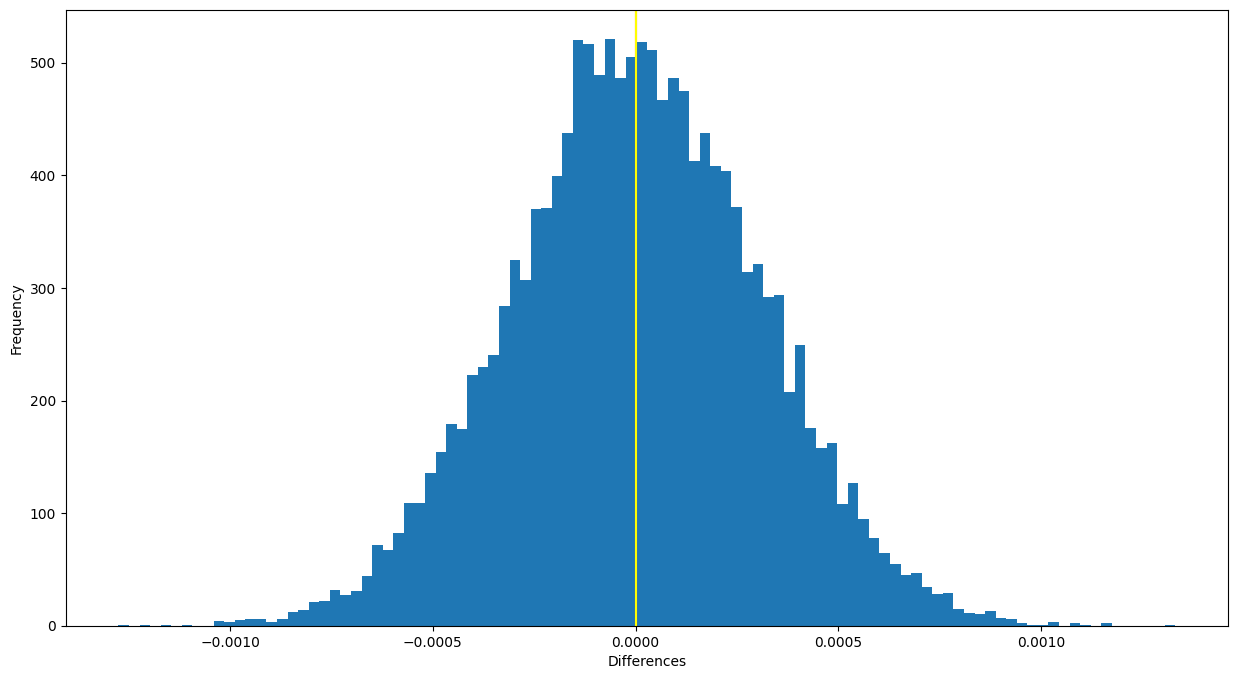

In [29]:
# calculating observed difference
obs_diff = violent_notdaylight - violent_isdaylight

# plot the results
plt.figure(figsize = (15,8))
plt.hist(p_diffs, bins = 100)
plt.axvline(p_diffs.mean(), color = 'red', label = 'Simulated Difference')
plt.axvline(obs_diff, color = 'yellow', label = 'Observed Difference')
plt.xlabel("Differences")
plt.ylabel("Frequency");

In [30]:
print(f"Our observed difference is {obs_diff}.")
print(f"The proportion of p_diffs greater than observed difference is(p-value): \
{(p_diffs > obs_diff).mean()}")

Our observed difference is 0.0.
The proportion of p_diffs greater than observed difference is(p-value): 0.499


Since our p-value exceeds the Type 1 Error threshold of 0.05, we fail to reject the null hypothesis. This indicates strong evidence in support of the null hypothesis. Given that the p-value is greater than 0.05, we can conclude that the result is not statistically significant. Consequently, this suggests that the violent crime rate in London is not significantly higher when daylight saving is not in effect.

Using the `proportions_ztest` method, we can see that we have also achieved similar results. Please refer to [this link for how to import and use it](https://www.statsmodels.org/devel/generated/statsmodels.stats.proportion.proportions_ztest.html).

In [31]:
isdaylight_violent_count = crime_df[crime_df.daylight_saving == 1]['violent'].sum()
notdaylight_violent_count = crime_df[crime_df.daylight_saving == 0]['violent'].sum()

n_notdaylight = crime_df.query("daylight_saving == 0").shape[0]
n_isdaylight = crime_df.query("daylight_saving == 1").shape[0]

In [32]:
z_score, pval = proportions_ztest([isdaylight_violent_count, notdaylight_violent_count], 
                                           [n_isdaylight, n_notdaylight], alternative = 'larger')
z_score, pval

(0.0, 0.5)

From our calculations, we determined the z-score and the p-value. The z-score represents the difference between our test statistics, which, in this context, is the difference in violent crime rates when daylight saving is and isn't in effect. After conducting the test, we observed that our null hypothesis lies 0 standard deviations above the mean, and the p-value remains above our alpha threshold (Type I Error rate) of 0.05. Consequently, we conclude that the violent crime rates are not statistically different from one another, providing no grounds to reject the null hypothesis.

Nevertheless, I would like to explore an alternative method: the regression approach.

## 7. Regression Approach

However, please note that our null and alternative hypotheses have been updated as follows:<br>
Null Hypothesis: The difference between the violent crime rates when daylight saving is and isn't in effect is equal to 0. This implies that there is no difference in violent crime rates based on daylight saving time.<br><br>
    "$$H_0: p_{notdaylight} - p_{isdaylight} = 0$$
Alternative Hypothesis: The difference between the violent crime rates when daylight saving is and isn't in effect is not equal to 0.<br><br>
    "$$H_1: p_{notdaylight} - p_{isdaylight} \\neq 0$$
 
This change reflects the use of a two-sided t-test, as opposed to the one-sided test we previously considered.

In [33]:
crime_df2 = crime_df.copy()

In [34]:
# create intercept
crime_df2['intercept'] = 1

# Instantiate and fit the model
logit_mod = sm.Logit(crime_df2['violent'], crime_df2[['intercept', 'daylight_saving']])
results = logit_mod.fit()

# provide summary of the model
results.summary()

Optimization terminated successfully.
         Current function value: 0.668798
         Iterations 4


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                violent   No. Observations:             13490604
Model:                          Logit   Df Residuals:                 13490602
Method:                           MLE   Df Model:                            1
Date:                Sun, 02 Feb 2025   Pseudo R-squ.:               1.708e-10
Time:                        09:06:32   Log-Likelihood:            -9.0225e+06
converged:                       True   LL-Null:                   -9.0225e+06
Covariance Type:            nonrobust   LLR p-value:                    0.9557
===================================================================================
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
intercept          -0.4468      0.001   -400.277      0.000      -0.449      -0.445
daylight_saving  1.151e-15      0.001   8.93e-13      1.000      -0.003       0.003
===================================================================================
"""

As observed, the p-value has increased to 1, which is even higher than our previous calculation. This model aims to predict the likelihood of a violent crime occurring based on whether daylight saving is in effect. The elevated p-value can be attributed to the intercept, which is designed to account for bias and improve the accuracy of the p-value. While we are closer to the true p-value, we still lack sufficient evidence to reject the null hypothesis. Furthermore, our model has failed—quite miserably, I might add.

Now that we have the model's results, it's time to explore other variables that could influence the violent crime rate. Next, we will consider the impact of location.

In [35]:
all_borough = list(crime_df2.borough.unique())
crime_df2[all_borough] = pd.get_dummies(crime_df2.borough)

crime_df2.head()

,lsoa_code,borough,major_category,minor_category,value,year,month,violent,daylight_saving,intercept,Croydon,Greenwich,Bromley,Redbridge,Wandsworth,Ealing,Hounslow,Newham,Sutton,Haringey,Lambeth,Richmond upon Thames,Hillingdon,Havering,Barking and Dagenham,Kingston upon Thames,Westminster,Hackney,Enfield,Harrow,Lewisham,Brent,Southwark,Barnet,Waltham Forest,Camden,Bexley,Kensington and Chelsea,Islington,Tower Hamlets,Hammersmith and Fulham,Merton,City of London
0,E01001116,Croydon,Burglary,Burglary in Other Buildings,0,2016,11,1,1,1,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
1,E01001646,Greenwich,Violence Against the Person,Other violence,0,2016,11,1,1,1,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
2,E01000677,Bromley,Violence Against the Person,Other violence,0,2015,5,1,1,1,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
3,E01003774,Redbridge,Burglary,Burglary in Other Buildings,0,2016,3,1,1,1,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False
4,E01004563,Wandsworth,Robbery,Personal Property,0,2008,6,1,1,1,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False


In [36]:
interest_vars = all_borough[:-1]
interest_vars.append('intercept')

# Convert boolean columns to integers
crime_df2[interest_vars] = crime_df2[interest_vars].astype(int)

# we will use the City of London as our baseline
# this might take a while since we have a quite a lot of variables
logit_mod = sm.Logit(crime_df2['violent'], crime_df2[interest_vars])
results = logit_mod.fit()
results.summary()

Optimization terminated successfully.
         Current function value: 0.668760
         Iterations 4


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                violent   No. Observations:             13490604
Model:                          Logit   Df Residuals:                 13490571
Method:                           MLE   Df Model:                           32
Date:                Sun, 02 Feb 2025   Pseudo R-squ.:               5.675e-05
Time:                        09:08:30   Log-Likelihood:            -9.0220e+06
converged:                       True   LL-Null:                   -9.0225e+06
Covariance Type:            nonrobust   LLR p-value:                1.442e-194
==========================================================================================
                             coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------
Croydon                    0.0323      0.005      6.463      0.000       0.023       0.042
Greenwich                  0.0330      0.004      7.612      0.000       0.025       0.042
Bromley                    0.0462      0.005      9.780      0.000       0.037       0.056
Redbridge                  0.0198      0.004      4.426      0.000       0.011       0.029
Wandsworth                 0.0182      0.004      4.108      0.000       0.009       0.027
Ealing                    -0.0072      0.005     -1.502      0.133      -0.016       0.002
Hounslow                   0.0177      0.021      0.841      0.400      -0.024       0.059
Newham                     0.0568      0.004     13.216      0.000       0.048       0.065
Sutton                     0.0225      0.004      5.130      0.000       0.014       0.031
Haringey                   0.0252      0.004      5.668      0.000       0.016       0.034
Lambeth                    0.0471      0.005     10.176      0.000       0.038       0.056
Richmond upon Thames       0.0110      0.005      2.357      0.018       0.002       0.020
Hillingdon                -0.0194      0.005     -3.933      0.000      -0.029      -0.010
Havering                   0.0230      0.005      4.934      0.000       0.014       0.032
Barking and Dagenham       0.0341      0.005      7.119      0.000       0.025       0.044
Kingston upon Thames       0.0394      0.005      8.403      0.000       0.030       0.049
Westminster                0.0222      0.005      4.837      0.000       0.013       0.031
Hackney                    0.0020      0.005      0.428      0.668      -0.007       0.011
Enfield                    0.0222      0.005      4.612      0.000       0.013       0.032
Harrow                    -0.0264      0.005     -5.190      0.000      -0.036      -0.016
Lewisham                  -0.0042      0.005     -0.798      0.425      -0.015       0.006
Brent                      0.0221      0.004      4.991      0.000       0.013       0.031
Southwark                  0.0291      0.004      6.470      0.000       0.020       0.038
Barnet                     0.0086      0.005      1.755      0.079      -0.001       0.018
Waltham Forest             0.0326      0.005      7.225      0.000       0.024       0.042
Camden                     0.0361      0.005      7.892      0.000       0.027       0.045
Bexley                     0.0116      0.005      2.300      0.021       0.002       0.021
Kensington and Chelsea     0.0090      0.004      2.000      0.046       0.000       0.018
Islington                  0.0357      0.005      7.210      0.000       0.026       0.045
Tower Hamlets              0.0166      0.005      3.567      0.000       0.007       0.026
Hammersmith and Fulham     0.0445      0.005      9.526      0.000       0.035       0.054
Merton                     0.0309      0.004      6.927      0.000       0.022       0.040
intercept                 -0.4697      0.003   -138.378 

Wow! There are numerous p-values below our threshold of 0.05. It would be more productive to identify the variables that exceed this threshold. Here is a list of locations where the p-value is greater than our threshold: Ealing, Hounslow, Hackney, Lewisham, and Barnet. This indicates that these locations do not have a significant impact on the violent crime rate. A quick Google search reveals that some of these areas are highly sought-after and relatively upscale compared to others.

Having examined the individual factors of location/borough and daylight savings, I now want to explore the interaction between these two variables to determine if there is any significant effect on the violent crime rate. I will create the necessary columns in this notebook, but the modeling and fitting will be conducted in a separate notebook due to the kernel crashing caused by the size of the new dataset.

In [37]:
# create the new columns' name
all_borough_daylight = '_daylight,'.join(all_borough)
all_borough_daylight = list(all_borough_daylight.split(','))[:-1]

In [38]:
all_borough_daylight

['Croydon_daylight',
 'Greenwich_daylight',
 'Bromley_daylight',
 'Redbridge_daylight',
 'Wandsworth_daylight',
 'Ealing_daylight',
 'Hounslow_daylight',
 'Newham_daylight',
 'Sutton_daylight',
 'Haringey_daylight',
 'Lambeth_daylight',
 'Richmond upon Thames_daylight',
 'Hillingdon_daylight',
 'Havering_daylight',
 'Barking and Dagenham_daylight',
 'Kingston upon Thames_daylight',
 'Westminster_daylight',
 'Hackney_daylight',
 'Enfield_daylight',
 'Harrow_daylight',
 'Lewisham_daylight',
 'Brent_daylight',
 'Southwark_daylight',
 'Barnet_daylight',
 'Waltham Forest_daylight',
 'Camden_daylight',
 'Bexley_daylight',
 'Kensington and Chelsea_daylight',
 'Islington_daylight',
 'Tower Hamlets_daylight',
 'Hammersmith and Fulham_daylight',
 'Merton_daylight']

In [39]:
crime_df3 = crime_df2.copy()
crime_df3 

,lsoa_code,borough,major_category,minor_category,value,year,month,violent,daylight_saving,intercept,Croydon,Greenwich,Bromley,Redbridge,Wandsworth,Ealing,Hounslow,Newham,Sutton,Haringey,Lambeth,Richmond upon Thames,Hillingdon,Havering,Barking and Dagenham,Kingston upon Thames,Westminster,Hackney,Enfield,Harrow,Lewisham,Brent,Southwark,Barnet,Waltham Forest,Camden,Bexley,Kensington and Chelsea,Islington,Tower Hamlets,Hammersmith and Fulham,Merton,City of London
0,E01001116,Croydon,Burglary,Burglary in Other Buildings,0,2016,11,1,1,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,False
1,E01001646,Greenwich,Violence Against the Person,Other violence,0,2016,11,1,1,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,False
2,E01000677,Bromley,Violence Against the Person,Other violence,0,2015,5,1,1,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,False
3,E01003774,Redbridge,Burglary,Burglary in Other Buildings,0,2016,3,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,False
4,E01004563,Wandsworth,Robbery,Personal Property,0,2008,6,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13490599,E01000504,Brent,Criminal Damage,Criminal Damage To Dwelling,0,2015,2,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,False
13490600,E01002504,Hillingdon,Robbery,Personal Property,1,2015,6,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,False
13490601,E01004165,Sutton,Burglary,Burglary in a Dwelling,0,2011,2,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,False
13490602,E01001134,Croydon,Robbery,Business Property,0,2011,5,1,1,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,False


In [40]:
# multiply 'daylight_saving' and each borough columns to create interactions between the two variables
new_crime =crime_df3[crime_df3.columns[10:-1]].multiply(crime_df3["daylight_saving"], axis="index")

# rename columns
col_rename_dict = {i:j for i,j in zip(crime_df3.columns[10:-1],all_borough_daylight)}
new_crime.rename(columns=col_rename_dict, inplace=True)
new_crime.head()

,Croydon_daylight,Greenwich_daylight,Bromley_daylight,Redbridge_daylight,Wandsworth_daylight,Ealing_daylight,Hounslow_daylight,Newham_daylight,Sutton_daylight,Haringey_daylight,Lambeth_daylight,Richmond upon Thames_daylight,Hillingdon_daylight,Havering_daylight,Barking and Dagenham_daylight,Kingston upon Thames_daylight,Westminster_daylight,Hackney_daylight,Enfield_daylight,Harrow_daylight,Lewisham_daylight,Brent_daylight,Southwark_daylight,Barnet_daylight,Waltham Forest_daylight,Camden_daylight,Bexley_daylight,Kensington and Chelsea_daylight,Islington_daylight,Tower Hamlets_daylight,Hammersmith and Fulham_daylight,Merton_daylight
0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1


In [41]:
# concat the two dataframes
combined_df = pd.concat([crime_df3, new_crime], axis=1)
combined_df.head()

,lsoa_code,borough,major_category,minor_category,value,year,month,violent,daylight_saving,intercept,Croydon,Greenwich,Bromley,Redbridge,Wandsworth,Ealing,Hounslow,Newham,Sutton,Haringey,Lambeth,Richmond upon Thames,Hillingdon,Havering,Barking and Dagenham,Kingston upon Thames,Westminster,Hackney,Enfield,Harrow,Lewisham,Brent,Southwark,Barnet,Waltham Forest,Camden,Bexley,Kensington and Chelsea,Islington,Tower Hamlets,Hammersmith and Fulham,Merton,City of London,Croydon_daylight,Greenwich_daylight,Bromley_daylight,Redbridge_daylight,Wandsworth_daylight,Ealing_daylight,Hounslow_daylight,Newham_daylight,Sutton_daylight,Haringey_daylight,Lambeth_daylight,Richmond upon Thames_daylight,Hillingdon_daylight,Havering_daylight,Barking and Dagenham_daylight,Kingston upon Thames_daylight,Westminster_daylight,Hackney_daylight,Enfield_daylight,Harrow_daylight,Lewisham_daylight,Brent_daylight,Southwark_daylight,Barnet_daylight,Waltham Forest_daylight,Camden_daylight,Bexley_daylight,Kensington and Chelsea_daylight,Islington_daylight,Tower Hamlets_daylight,Hammersmith and Fulham_daylight,Merton_daylight
0,E01001116,Croydon,Burglary,Burglary in Other Buildings,0,2016,11,1,1,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,False,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,E01001646,Greenwich,Violence Against the Person,Other violence,0,2016,11,1,1,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,False,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,E01000677,Bromley,Violence Against the Person,Other violence,0,2015,5,1,1,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,False,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,E01003774,Redbridge,Burglary,Burglary in Other Buildings,0,2016,3,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,False,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
4,E01004563,Wandsworth,Robbery,Personal Property,0,2008,6,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,False,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1


In [42]:
# save new dataframe to csv file for fitting and modeling
combined_df.to_csv('london_crime_final.csv', index = False)

## 8. Individual Factors of Daylight 

In [43]:
crime_final_df = pd.read_csv('london_crime_final.csv')
crime_final_df.head()

,lsoa_code,borough,major_category,minor_category,value,year,month,violent,daylight_saving,intercept,Croydon,Greenwich,Bromley,Redbridge,Wandsworth,Ealing,Hounslow,Newham,Sutton,Haringey,Lambeth,Richmond upon Thames,Hillingdon,Havering,Barking and Dagenham,Kingston upon Thames,Westminster,Hackney,Enfield,Harrow,Lewisham,Brent,Southwark,Barnet,Waltham Forest,Camden,Bexley,Kensington and Chelsea,Islington,Tower Hamlets,Hammersmith and Fulham,Merton,City of London,Croydon_daylight,Greenwich_daylight,Bromley_daylight,Redbridge_daylight,Wandsworth_daylight,Ealing_daylight,Hounslow_daylight,Newham_daylight,Sutton_daylight,Haringey_daylight,Lambeth_daylight,Richmond upon Thames_daylight,Hillingdon_daylight,Havering_daylight,Barking and Dagenham_daylight,Kingston upon Thames_daylight,Westminster_daylight,Hackney_daylight,Enfield_daylight,Harrow_daylight,Lewisham_daylight,Brent_daylight,Southwark_daylight,Barnet_daylight,Waltham Forest_daylight,Camden_daylight,Bexley_daylight,Kensington and Chelsea_daylight,Islington_daylight,Tower Hamlets_daylight,Hammersmith and Fulham_daylight,Merton_daylight
0,E01001116,Croydon,Burglary,Burglary in Other Buildings,0,2016,11,1,1,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,False,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,E01001646,Greenwich,Violence Against the Person,Other violence,0,2016,11,1,1,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,False,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,E01000677,Bromley,Violence Against the Person,Other violence,0,2015,5,1,1,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,False,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,E01003774,Redbridge,Burglary,Burglary in Other Buildings,0,2016,3,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,False,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
4,E01004563,Wandsworth,Robbery,Personal Property,0,2008,6,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,False,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1


In [44]:
interested_var = list(crime_final_df.columns[8:])
# remove 'City of London' from list since its our baseline
interested_var.remove('City of London')
interested_var

['daylight_saving',
 'intercept',
 'Croydon',
 'Greenwich',
 'Bromley',
 'Redbridge',
 'Wandsworth',
 'Ealing',
 'Hounslow',
 'Newham',
 'Sutton',
 'Haringey',
 'Lambeth',
 'Richmond upon Thames',
 'Hillingdon',
 'Havering',
 'Barking and Dagenham',
 'Kingston upon Thames',
 'Westminster',
 'Hackney',
 'Enfield',
 'Harrow',
 'Lewisham',
 'Brent',
 'Southwark',
 'Barnet',
 'Waltham Forest',
 'Camden',
 'Bexley',
 'Kensington and Chelsea',
 'Islington',
 'Tower Hamlets',
 'Hammersmith and Fulham',
 'Merton',
 'Croydon_daylight',
 'Greenwich_daylight',
 'Bromley_daylight',
 'Redbridge_daylight',
 'Wandsworth_daylight',
 'Ealing_daylight',
 'Hounslow_daylight',
 'Newham_daylight',
 'Sutton_daylight',
 'Haringey_daylight',
 'Lambeth_daylight',
 'Richmond upon Thames_daylight',
 'Hillingdon_daylight',
 'Havering_daylight',
 'Barking and Dagenham_daylight',
 'Kingston upon Thames_daylight',
 'Westminster_daylight',
 'Hackney_daylight',
 'Enfield_daylight',
 'Harrow_daylight',
 'Lewisham_dayli

In [45]:
logit_mod = sm.Logit(crime_final_df['violent'], crime_final_df[interested_var])
results = logit_mod.fit()

results.summary()

Optimization terminated successfully.
         Current function value: 0.668760
         Iterations 4


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                violent   No. Observations:             13490604
Model:                          Logit   Df Residuals:                 13490538
Method:                           MLE   Df Model:                           65
Date:                Sun, 02 Feb 2025   Pseudo R-squ.:               5.675e-05
Time:                        09:49:19   Log-Likelihood:            -9.0220e+06
converged:                       True   LL-Null:                   -9.0225e+06
Covariance Type:            nonrobust   LLR p-value:                2.128e-172
===================================================================================================
                                      coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
daylight_saving                 -1.235e-15      0.008  -1.58e-13      1.000      -0.015       0.015
intercept                          -0.4697      0.007    -69.189      0.000      -0.483      -0.456
Croydon                             0.0323      0.010      3.231      0.001       0.013       0.052
Greenwich                           0.0330      0.009      3.806      0.000       0.016       0.050
Bromley                             0.0462      0.009      4.890      0.000       0.028       0.065
Redbridge                           0.0198      0.009      2.213      0.027       0.002       0.037
Wandsworth                          0.0182      0.009      2.054      0.040       0.001       0.035
Ealing                             -0.0072      0.010     -0.751      0.453      -0.026       0.012
Hounslow                            0.0177      0.042      0.421      0.674      -0.065       0.100
Newham                              0.0568      0.009      6.608      0.000       0.040       0.074
Sutton                              0.0225      0.009      2.565      0.010       0.005       0.040
Haringey                            0.0252      0.009      2.834      0.005       0.008       0.043
Lambeth                             0.0471      0.009      5.088      0.000       0.029       0.065
Richmond upon Thames                0.0110      0.009      1.179      0.239      -0.007       0.029
Hillingdon                         -0.0194      0.010     -1.967      0.049      -0.039   -6.57e-05
Havering                            0.0230      0.009      2.467      0.014       0.005       0.041
Barking and Dagenham                0.0341      0.010      3.560      0.000       0.015       0.053
Kingston upon Thames                0.0394      0.009      4.201      0.000       0.021       0.058
Westminster                         0.0222      0.009      2.419      0.016       0.004       0.040
Hackney                             0.0020      0.009      0.214      0.830      -0.016       0.020
Enfield                             0.0222      0.010      2.306      0.021       0.003       0.041
Harrow                             -0.0264      0.010     -2.595      0.009      -0.046      -0.006
Lewisham                           -0.0042      0.011     -0.399      0.690      -0.025       0.016
Brent                               0.0221      0.009      2.495      0.013       0.005       0.039
Southwark                           0.0291      0.009      3.235      0.001       0.011       0.047
Barnet                              0.0086      0.010      0.878      0.380      -0.011       0.028
Waltham Forest                      0.0326      0.009      3.613      0.000       0.015       0.050
Camden                              0.0361      0.009      3.946      0.000       0.018       0.054
Bexley                              0.0116      0.010      1.150      0.250      -0.008       0.031
Kensington and Chelsea              0.009

## CONCLUSIONS

It doesn’t seem like much has changed overall, but there is one notable difference. The p-values for Richmond upon Thames, Kensington & Chelsea, and Tower Hamlets have increased, placing them above our 0.05 threshold. This suggests that adding these extra variables (interactions) has only amplified the p-values.

At the beginning (in Notebook I), we discovered that the violent crime rate is not dependent on the daylight saving effect. However, the location does appear to influence the rate. As a result, we do not have sufficient evidence to accept our alternative hypothesis that the violent crime rate is higher when daylight saving is not in effect. Instead, our focus should shift to the locations, as there are several statistically significant results where the p-value is below our alpha threshold.

When we introduced additional variables in Part II, we observed that some locations' p-values increased beyond the threshold. Some locations that initially supported the null hypothesis no longer did so after adding these variables. In this second test, we found that the interactions between daylight savings and borough are not statistically significant. This means that the result is not dependent on these interactions, and the p-value is large enough for us to fail to reject the null hypothesis.

Therefore, I recommend focusing on the locations/boroughs that are statistically significant (p-value < 0.05) rather than those that are not (p-value > 0.05), regardless of daylight saving status, if the primary focus is solely on violent crimes.